<a href="https://colab.research.google.com/github/hsiuchun/NLP/blob/main/Semantic_Analysis_BERT_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 情緒分析

資料集: [Learning Word Vectors for Sentiment Analysis](https://aclanthology.org/P11-1015.pdf)

程式碼參考自: [huggingface](https://huggingface.co/)

> **資料集說明**

Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.

>**本次介紹模型為BERT**

[BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://github.com/google-research/bert)

程式碼參考自: [huggingface](https://huggingface.co/)

![](https://i.imgur.com/spiKPbQ.png)

[可搭配李宏毅大大的說明影片食用](https://youtu.be/UYPa347-DdE)

**訓練一個BERT分類模型，輸入是一句話，辨識出這句話的情緒傾向。**

## 定義你的 Hyperparameters

* 如果電腦的記憶體不夠可以試著減少 batch_size
* 因為我們採用現有的模型去fine-tune，所以一般不需要設太多 epochs
* config 就是我們所使用的現有模型，可以自己找適合的做替換
* 這次是做二分類所以 num_class 是 2
* 如果你的模型 overfit 了，可以把 dropout 調高
* 可以試著調高或調低 learning_rate，這會影響他的學習速度（跨步的大小）
* 你應該先檢閱你的資料再來決定 max_len （但 BERT 最大只吃到 512）

In [1]:
from datetime import datetime
parameters = {
    "num_class": 2,
    "time": str(datetime.now()).replace(" ", "_"),
    "seed": 1111,
    # Hyperparameters
    "model_name": 'BERT',
    "config": 'bert-base-uncased',
    "learning_rate": 1e-4,
    "epochs": 3,
    "max_len": 512,
    "batch_size": 16,
    "dropout": 0.1,
    "activation": 'Prelu',
    "hidden_dim": 384,
}

## 資料集準備

- 資料集說明 :
  - text: a string feature.
  - label: a classification label, with possible values including neg (0), pos (1).

### 載入資料

安裝 huggingface 的 dataset 套件（可以直接透過 pip 安裝是不是很方便）

In [2]:
!pip install datasets

In [3]:
from datasets import load_dataset

dataset = load_dataset("imdb")

看一下資料格式長怎樣

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [5]:
dataset['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

結合 huggingface 上 imdb 的介紹 及圖 2，我們可以發現 unsupervised 的資料是沒有正負向標籤的，因此本次只採用 train 與 test 資料。

在這步驟，我們需要將原資料重新進行分割。將 train 與 test 資料合併後切割成 3:1:1 或是 8:1:1 的一組新的 train/val/test 資料集。

把資料拿出來後，將train及test合併，重新切割後，儲存下來。


---


作者於此處將資料合併重切，是為了得到驗證集和增加訓練筆數。當然也可以直接從測試集直接 sample 驗證集，每個人的作法不一定相同～但若要與其他模型比較，需採用一致的測試集。

In [6]:
import pandas as pd

all_data = [] # a list to save all data

for data in dataset['train']:
  all_data.append({'text':data['text'], 'label':data['label']})
for data in dataset['test']:
  all_data.append({'text':data['text'], 'label':data['label']})

all_df = pd.DataFrame(all_data, columns=['text', 'label'])
all_df.head(5)

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [7]:
all_df.label.value_counts() / len(all_df)

0    0.5
1    0.5
Name: label, dtype: float64

In [8]:
from sklearn.model_selection import train_test_split

train_df, temp_data = train_test_split(all_df, random_state=1111, train_size=0.8)
val_df, test_df = train_test_split(temp_data, random_state=1111, train_size=0.5)
print('# of train_df:', len(train_df))
print('# of val_df:', len(val_df))
print('# of test_df data:', len(test_df))

# save data
train_df.to_csv('./train.tsv', sep='\t', index=False)
val_df.to_csv('./val.tsv', sep='\t', index=False)
test_df.to_csv('./test.tsv', sep='\t', index=False)

# of train_df: 40000
# of val_df: 5000
# of test_df data: 5000


### [Tokenizer 簡介](https://huggingface.co/docs/transformers/main_classes/tokenizer)

這邊會先帶大家快速走一遍 Tokenzier 是怎麼做的

In [9]:
!pip install transformers

In [10]:
from transformers import AutoTokenizer

In [11]:
config_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(config_name)

In [12]:
sample_s = "How's everything going?"
token = tokenizer.tokenize(sample_s)
print(token)

['how', "'", 's', 'everything', 'going', '?']


In [13]:
sample_s = "How's everything going?"
ids = tokenizer.encode(sample_s)
print(ids)

[101, 2129, 1005, 1055, 2673, 2183, 1029, 102]


In [14]:
tokenizer.decode(ids)

"[CLS] how's everything going? [SEP]"

In [15]:
print(tokenizer.convert_ids_to_tokens(ids))
print(tokenizer.convert_tokens_to_ids(token))
print(tokenizer.convert_tokens_to_string(token))

['[CLS]', 'how', "'", 's', 'everything', 'going', '?', '[SEP]']
[2129, 1005, 1055, 2673, 2183, 1029]
how ' s everything going?


In [16]:
sample_s = "How's everything going?"
es = tokenizer.encode_plus(sample_s)
print(es)

{'input_ids': [101, 2129, 1005, 1055, 2673, 2183, 1029, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


In [17]:
inputs = tokenizer.encode_plus(
    sample_s,
    max_length = 7,
    truncation = True,
    padding = 'max_length',
    return_tensors = 'pt'
)
print(inputs)

{'input_ids': tensor([[ 101, 2129, 1005, 1055, 2673, 2183,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


In [18]:
sample_os = "How are you?"
os = tokenizer.encode_plus(
    sample_os,
    max_length = 7,
    truncation = True,
    padding = 'max_length'
)
print(os)

{'input_ids': [101, 2129, 2024, 2017, 1029, 102, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 0]}


### 自定義 Dataset，將tokenzie的步驟放進去

In [19]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import torch
import torch.nn.functional as Fun

# Using Dataset to build DataLoader
class CustomDataset(Dataset):
    def __init__(self, mode, df, specify, args):
        assert mode in ["train", "val", "test"]  # 一般會切三份
        self.mode = mode
        self.df = df
        self.specify = specify # specify column of data (the column U use for predict)
        if self.mode != 'test':
          self.label = df['label']
        self.tokenizer = AutoTokenizer.from_pretrained(args["config"])
        self.max_len = args["max_len"]
        self.num_class = args["num_class"]

    def __len__(self):
        return len(self.df)

    # transform label to one_hot label (if num_class > 2)
    def one_hot_label(self, label):
        return Fun.one_hot(torch.tensor(label), num_classes = self.num_class)

    # transform text to its number
    def tokenize(self,input_text):
        inputs = self.tokenizer.encode_plus(
            input_text,
            max_length = self.max_len,
            truncation = True,
            padding = 'max_length'
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return ids,mask,token_type_ids

    # get single data
    def __getitem__(self, index):

        sentence = str(self.df[self.specify][index])
        ids, mask, token_type_ids = self.tokenize(sentence)


        if self.mode == "test":
            return torch.tensor(ids, dtype=torch.long), torch.tensor(mask, dtype=torch.long), \
                torch.tensor(token_type_ids, dtype=torch.long)
        else:
            if self.num_class > 2:
              return torch.tensor(ids, dtype=torch.long), torch.tensor(mask, dtype=torch.long), \
                torch.tensor(token_type_ids, dtype=torch.long), self.one_hot_label(self.label[index])
            else:
              return torch.tensor(ids, dtype=torch.long), torch.tensor(mask, dtype=torch.long), \
                torch.tensor(token_type_ids, dtype=torch.long), torch.tensor(self.label[index], dtype=torch.long)

### 建立 DataLoader

讀入資料並傳入自定的 Dataset 以自訂資料格式

之後傳入DataLoader以利後續訓練進行（將資料批次化以免記憶體爆掉）

In [20]:
import transformers
import pandas as pd

# load training data
train_df = pd.read_csv('./train.tsv', sep = '\t').sample(4000, random_state=parameters['seed']).reset_index(drop=True)
train_dataset = CustomDataset('train', train_df, 'text', parameters)
train_loader = DataLoader(train_dataset, batch_size=parameters['batch_size'], shuffle=True)

# load validation data
val_df = pd.read_csv('./val.tsv', sep = '\t').sample(500, random_state=parameters['seed']).reset_index(drop=True)
val_dataset = CustomDataset('val', val_df, 'text', parameters)
val_loader = DataLoader(val_dataset, batch_size=parameters['batch_size'], shuffle=True)

In [21]:
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter

## 建立模型

*   自己重新寫分類模型
*   模型訓練與評估的程式碼大致上相同，差別在於模型是否繼續進行梯度下降，以及模型參數是否繼續訓練



### train utils

In [22]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

# get predict result
def get_pred(logits):
    y_pred = torch.argmax(logits, dim = 1)
    return y_pred

# calculate confusion metrics
def cal_metrics(pred, ans, method):
    '''
    Parameter
    ---------
    pred: [list], predict class
    ans: [list], true class
    method: 'micro', 'weighted', 'macro'.
    ---------
    '''
    if pred.get_device() != 'cpu':
        pred = pred.detach().cpu().numpy()
    if ans.get_device() != 'cpu':
        ans = ans.detach().cpu().numpy()
    rec = recall_score(pred, ans, average=method, zero_division=0)
    f1 = f1_score(pred, ans, average=method, zero_division=0)
    prec = precision_score(pred, ans, average=method, zero_division=0)
    acc = accuracy_score(pred, ans)
    return acc, f1, rec, prec

In [23]:
# save model to path
def save_checkpoint(save_path, model):
    if save_path == None:
        return
    torch.save(model.state_dict(), save_path)
    print(f'Model saved to ==> {save_path}')

# load model from path
def load_checkpoint(load_path, model, device):
    if load_path==None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    model.load_state_dict(state_dict)
    return model

In [24]:
import matplotlib.pyplot as plt

# draw the learning curve
def draw_pic(record, name, img_save=False, show=False):
    x_ticks = range(1, parameters["epochs"]+1)

    plt.figure(figsize=(6, 3))

    plt.plot(x_ticks, record['train_'+name], '-o', color='lightskyblue',
             markeredgecolor="teal", markersize=3, markeredgewidth=1, label = 'Train')
    plt.plot(x_ticks, record['val_'+name], '-o', color='pink',
             markeredgecolor="salmon", markersize=3, markeredgewidth=1, label = 'Val')
    plt.grid(color='lightgray', linestyle='--', linewidth=1)

    plt.title('Model', fontsize=14)
    plt.ylabel(name, fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.xticks(x_ticks, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='lower right' if not name.lower().endswith('loss') else 'upper right')

    if img_save:
        plt.savefig(name+'.png', transparent=False, dpi=300)
    if show:
        plt.show()

    plt.close()

In [25]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.base import MIMEBase
from email import encoders

def send_email(hyperparameters, png_files):

    # create MIMEMultipart
    msg = MIMEMultipart()

    # define sender and receiver, U need to change this for yours
    msg['From'] = 'YOUR EMAIL ACCOUNT'
    msg['To'] = 'YOUR EMAIL ACCOUNT'

    msg['Subject'] = 'Training Result'

    # create text content
    text = MIMEText(f'{hyperparameters}\n\n')
    msg.attach(text)

    # read png
    for file in png_files:
        with open(file, 'rb') as fp:
            image = MIMEBase('application', "octet-stream")
            image.set_payload(fp.read())
        encoders.encode_base64(image)
        image.add_header('Content-Disposition', 'attachment', filename=file)
        msg.attach(image)

    # 建立 SMTP 服務
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.ehlo()
    server.starttls()
    server.login('YOUR EMAIL ACCOUNT',  'YOUR EMAIL PASSWOED') # U need to change this for yours

    server.send_message(msg)  # send email
    server.quit()  # close the email channel

### model

In [26]:
import torch.nn as nn

# define different activation function
def get_activation(activation):
    if activation == 'Prelu':
        return nn.PReLU()
    elif activation == 'relu':
        return nn.ReLU()
    elif activation == 'sigmoid':
        return nn.Sigmoid()
    elif activation == 'gelu':
        return nn.GELU()
    elif activation == 'LeakyReLU':
        return nn.LeakyReLU()
    else:
        return nn.Tanh()

# Dense Layer
# It is composed of linear, (dropout), and activation layers.
# dropout is optional, and activation is needed when there is more than one linear layer
class Dense(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate, activation='tanh'):
        super(Dense, self).__init__()

        self.hidden_layer = nn.Linear(input_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = get_activation(activation) # default tanh
        nn.init.xavier_uniform_(self.hidden_layer.weight) # you also can change the initialize method

    def forward(self, inputs):
        logits = self.hidden_layer(inputs)
        logits = self.dropout(logits)
        logits = self.activation(logits)

        return logits

In [27]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertModel
import torch.nn as nn

# BERT Model
class BertClassifier(BertPreTrainedModel):
    def __init__(self, config, args):
        super(BertClassifier, self).__init__(config)
        self.bert = BertModel(config)
        self.num_labels = args["num_class"]
        self.dropout = nn.Dropout(args["dropout"])
        self.classifier = nn.Linear(config.hidden_size, self.num_labels)
        self.init_weights()

    # forward function, data in model will do this
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, position_ids=None,
                head_mask=None, inputs_embeds=None, labels=None, output_attentions=None,
                output_hidden_states=None, return_dict=None):

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # bert output
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict
        )
        '''
        outputs.keys() -> odict_keys(['last_hidden_state', 'pooler_output'])
        outs.last_hidden_state.shape -> torch.Size([batch_size, 512, 768])
        outs.pooler_output.shape -> torch.Size([batch_size, 768])
        '''

        # get its [CLS] logits
        pooled_output = outputs[1] # (batch_size, 768)
        # add dense layer
        pooled_output = self.dropout(pooled_output) # (batch_size, 768)
        # add linear classifier
        logits = self.classifier(pooled_output) # (batch_size, 2)

        return logits

In [28]:
# evaluate dataloader
def evaluate(model, data_loader, device):
    val_loss, val_acc, val_f1, val_rec, val_prec = 0.0, 0.0, 0.0, 0.0, 0.0
    step_count = 0
    loss_fct = nn.CrossEntropyLoss()
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            ids, masks, token_type_ids, labels = [t.to(device) for t in data]

            logits = model(input_ids = ids,
                    token_type_ids = token_type_ids,
                    attention_mask = masks)
            acc, f1, rec, prec = cal_metrics(get_pred(logits), labels, 'macro')
            loss = loss_fct(logits, labels)

            val_loss += loss.item()
            val_acc += acc
            val_f1 += f1
            val_rec += rec
            val_prec += prec
            step_count+=1

        val_loss = val_loss / step_count
        val_acc = val_acc / step_count
        val_f1 = val_f1 / step_count
        val_rec = val_rec / step_count
        val_prec = val_prec / step_count

    return val_loss, val_acc, val_f1, val_rec, val_prec

In [29]:
# Start training
import time

def train(model, train_loader, val_loader, optimizer, args, device):
  metrics = ['loss', 'acc', 'f1', 'rec', 'prec']
  mode = ['train_', 'val_']
  record = {s+m :[] for s in mode for m in metrics}

  for epoch in range(args["epochs"]):

      st_time = time.time()
      train_loss, train_acc, train_f1, train_rec, train_prec = 0.0, 0.0, 0.0, 0.0, 0.0
      step_count = 0

      model.train()
      for data in train_loader:

          ids, masks, token_type_ids, labels = [t.to(device) for t in data]

          optimizer.zero_grad()

          logits = model(input_ids = ids,
                  token_type_ids = token_type_ids,
                  attention_mask = masks)
          acc, f1, rec, prec = cal_metrics(get_pred(logits), labels, 'macro')
          loss = loss_fct(logits, labels)

          loss.backward()
          optimizer.step()

          train_loss += loss.item()
          train_acc += acc
          train_f1 += f1
          train_rec += rec
          train_prec += prec
          step_count += 1

      # evaluate the model performace on val data after finishing an epoch training
      val_loss, val_acc, val_f1, val_rec, val_prec = evaluate(model, val_loader, device)

      train_loss = train_loss / step_count
      train_acc = train_acc / step_count
      train_f1 = train_f1 / step_count
      train_rec = train_rec / step_count
      train_prec = train_prec / step_count

      print('[epoch %d] cost time: %.4f s'%(epoch + 1, time.time() - st_time))
      print('         loss     acc     f1      rec    prec')
      print('train | %.4f, %.4f, %.4f, %.4f, %.4f'%(train_loss, train_acc, train_f1, train_rec, train_prec))
      print('val  | %.4f, %.4f, %.4f, %.4f, %.4f\n'%(val_loss, val_acc, val_f1, val_rec, val_prec))

      # record training metrics of each training epoch
      record['train_loss'].append(train_loss)
      record['train_acc'].append(train_acc)
      record['train_f1'].append(train_f1)
      record['train_rec'].append(train_rec)
      record['train_prec'].append(train_prec)

      record['val_loss'].append(val_loss)
      record['val_acc'].append(val_acc)
      record['val_f1'].append(val_f1)
      record['val_rec'].append(val_rec)
      record['val_prec'].append(val_prec)

  # save model
  save_checkpoint(args["model_name"] + '_' + args["time"].split('_')[0] + '.pt', model)
  return record

## 開始訓練

### 初始化模型
*   載入模型（這邊會使用已經訓練過的模型，Fine-tune我們的資料集）
*   定義Optimization
  *   通常用Adam就可以了，你也可以換SGD之類的試看看
  *   可以自己看需不需要加scheduler（可以自己寫一個function，也可以直接套用現有的function）
  
  ［請記得pytorch中是以step去計算，想要用epoch去訂定需自行換算］




In [30]:
transformers.logging.set_verbosity_error() # close the warning message

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertClassifier.from_pretrained(parameters['config'], parameters).to(device)
loss_fct = torch.nn.CrossEntropyLoss() # we use cross entrophy loss

## You can custom your optimizer (e.g. SGD .etc) ##
# we use Adam here
optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'], betas=(0.9, 0.999), eps=1e-9)

## You also can add your custom scheduler ##
# num_train_steps = len(train_loader) * parameters['epochs]
# scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * num_train_steps), num_training_steps=num_train_steps, num_cycles=1)

訓練+畫圖

[epoch 1] cost time: 377.3754 s
         loss     acc     f1      rec    prec
train | 0.4743, 0.7482, 0.7188, 0.7475, 0.7540
val  | 0.3118, 0.8887, 0.8776, 0.8864, 0.8865

[epoch 2] cost time: 385.4104 s
         loss     acc     f1      rec    prec
train | 0.2511, 0.9042, 0.8957, 0.9104, 0.9029
val  | 0.2841, 0.8984, 0.8914, 0.8974, 0.8950

[epoch 3] cost time: 385.8103 s
         loss     acc     f1      rec    prec
train | 0.1221, 0.9580, 0.9546, 0.9596, 0.9586
val  | 0.3693, 0.8652, 0.8569, 0.8718, 0.8628

Model saved to ==> BERT_2023-10-07.pt


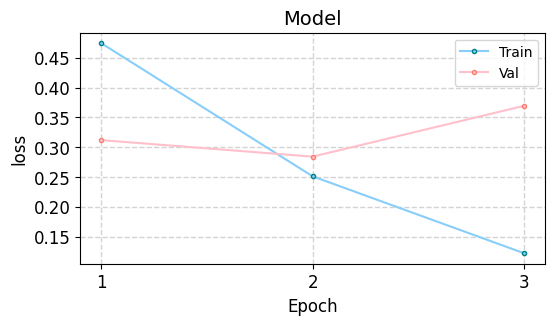

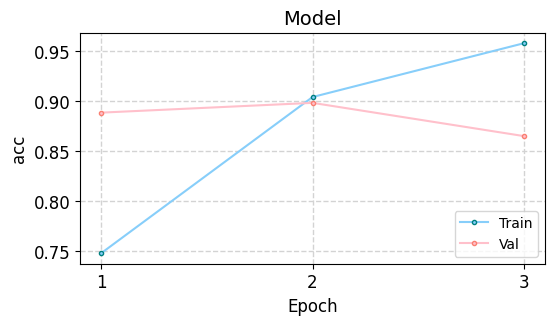

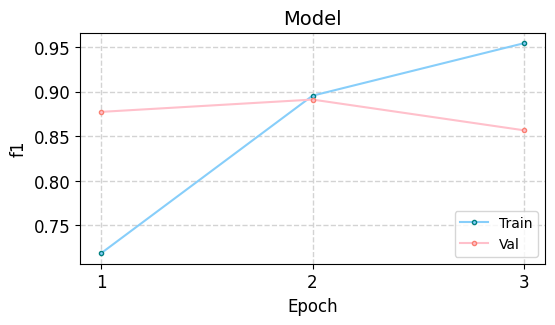

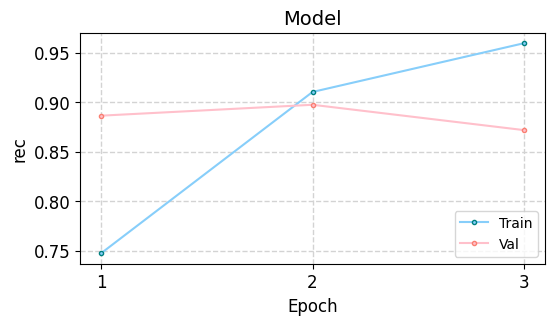

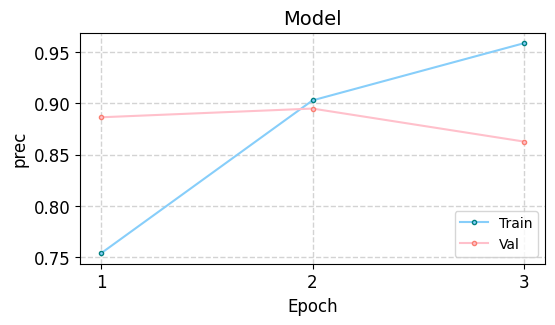

In [31]:
history = train(model, train_loader, val_loader, optimizer, parameters, device)

# draw all metrics figure
draw_pic(history, 'loss', img_save=True, show=True)
draw_pic(history, 'acc', img_save=True, show=True)
draw_pic(history, 'f1', img_save=True, show=True)
draw_pic(history, 'rec', img_save=True, show=True)
draw_pic(history, 'prec', img_save=True, show=True)

files = []
files.append('loss.png')
files.append('acc.png')
files.append('f1.png')
files.append('rec.png')
files.append('prec.png')
send_email(parameters, files)

## 預測結果

預測單筆（跟評估的程式大同小異）

（你也可以像evaluate function一樣，把它寫成dataloader的形式）



In [32]:
def Softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [33]:
# label to class
def label2class(label):
  l2c = {0:'negative', 1:'positive'}
  return l2c[label]

# predict single sentence
def predict_one(query, model):

  tokenizer = AutoTokenizer.from_pretrained(parameters['config'])
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model.eval()
  with torch.no_grad():
    inputs = tokenizer.encode_plus(
        query,
        max_length = parameters['max_len'],
        truncation = True,
        padding = 'max_length',
        return_tensors = 'pt'
    )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)

    # forward pass
    logits = model(input_ids, attention_mask, token_type_ids)
    probs = Softmax(logits) # get each class-probs
    label_index = torch.argmax(probs[0], dim=0)
    pred = label_index.item()

  return probs, pred


In [34]:
# you can load model from existing result
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
init_model = BertClassifier.from_pretrained(parameters['config'], parameters) # build an initial model
model = load_checkpoint('./BERT_2023-10-07.pt', init_model, device).to(device) # and load the weight of model from specify file

Model loaded from <== ./BERT_2023-10-07.pt


In [35]:
%%time
probs, pred = predict_one("This movie doesn't attract me", model)
print(probs, pred)
# print(label2class(pred))

tensor([[0.9779, 0.0221]], device='cuda:0') 0
CPU times: user 78.1 ms, sys: 4 ms, total: 82.1 ms
Wall time: 340 ms


In [36]:
# predict dataloader
def predict(data_loader, model):

  tokenizer = AutoTokenizer.from_pretrained(parameters['config'])
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  total_probs, total_pred = [], []
  model.eval()
  with torch.no_grad():
    for data in data_loader:
      input_ids, attention_mask, \
      token_type_ids = [t.to(device) for t in data]

      # forward pass
      logits = model(input_ids, attention_mask, token_type_ids)
      probs = Softmax(logits) # get each class-probs
      label_index = torch.argmax(probs[0], dim=0)
      pred = label_index.item()

      total_probs.append(probs)
      total_pred.append(pred)

  return total_probs, total_pred

In [37]:
# load testing data
test_df = pd.read_csv('./test.tsv', sep = '\t').sample(500).reset_index(drop=True)
test_dataset = CustomDataset('test', test_df, 'text', parameters)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

total_probs, total_pred = predict(test_loader, model)
res = test_df.copy()
# add predict class of origin file
res['pred'] = total_pred

# save result
res.to_csv('./result.tsv', sep='\t', index=False)

In [38]:
res.head(5)

,text,label,pred
0,I don't know how I would feel if I lived in US...,1,0
1,This sorry excuse for a film reminded me a gre...,0,0
2,A warmly sentimental tale from the author of T...,1,1
3,This is being commented on only because Serge ...,1,1
4,Despite the overwhelming cult following for th...,0,0


In [39]:
correct = 0
for idx, pred in enumerate(res['pred']):
  if pred == res['label'][idx]:
    correct += 1
print('test accuracy = %.4f'%(correct/len(test_df)))

test accuracy = 0.8600
